In [27]:
import os
import sys
module_path = r'C:\Users\adrian-boss\Documents\GitHub\BigDataCup\xT'
if module_path not in sys.path:
    sys.path.append(module_path)
import xT as xT
import pandas as pd
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import math
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score,log_loss,r2_score
from sklearn.model_selection import GridSearchCV,cross_val_score,cross_val_predict,train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import glob
from PIL import Image

In [28]:
data=pd.read_csv('data_pre_xg.csv')
og = data.copy()
x_cell,y_cell = xT._get_cell_indexes(data.start_x, data.start_y, l=16, w=8)
data['x_start_cell'] = x_cell
data['y_start_cell'] = y_cell
data=data[['x_start_cell','y_start_cell','sec_remaining','type_name','success',
           'league','skater_dif']]
data['d'] = ((15 - data['x_start_cell'])**2 + (3.5-data['y_start_cell'])**2)**(1/2)
data=data[data['league'] == 'scouting']
data=data[data['type_name'].isin(['Pass','Zone Entry'])]
data.drop(columns=['type_name','league','x_start_cell','y_start_cell'],inplace=True)
# Split train test -- 
Y = data['success']
X = data.drop(columns='success')
x, x_test, y, y_test = train_test_split(X, Y, test_size=0.20, random_state = 8)
# Features' names --
features = X.columns
#CV
param_grid = {
    'min_samples_leaf': [50, 100, 250, 500]
}
clf = RandomForestClassifier(n_estimators=100, random_state=42, verbose=2)
# Tune hyperparameters
cv_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5,scoring='neg_log_loss')
clf.verbose = False
cv_clf.fit(x,y)
print(cv_clf.best_params_)

{'min_samples_leaf': 50}


In [29]:
# Estimate prob - test set --
ytest_prob = cv_clf.predict_proba(x_test)[:, 1]
ytest_hat = cv_clf.predict(x_test)
test = pd.DataFrame(data={'xG':ytest_prob,'Predicted':ytest_hat},index= y_test.index)
test['Outcome'] = y_test
test['CPOE'] = test['Outcome'] - test['xG']
se = test['CPOE']**2
mse = se.values.mean()
rmse = math.sqrt(mse)
test_accuracy = log_loss(y_test.values,ytest_hat)
# Print Results --
#print('Gradient Boosting Classifier test log_loss: \n{:.2%}'.format(test_accuracy,4))
print('Test RMSE: \n{:.2%}'.format(rmse))
print('Test MSE: \n{:.2%}'.format(mse))

Test RMSE: 
43.25%
Test MSE: 
18.71%


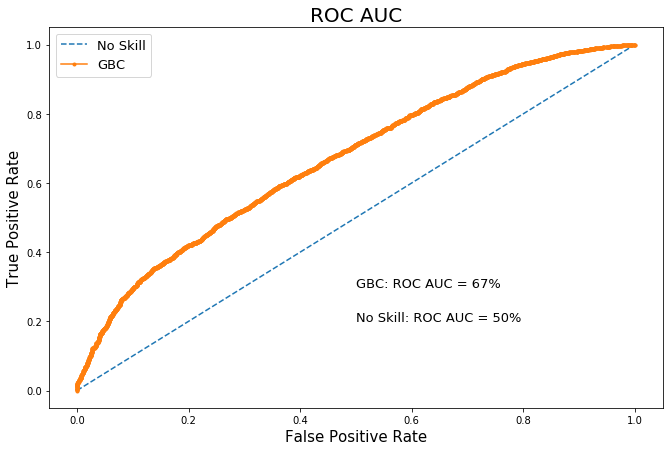

None


In [30]:
#Code from: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
lr_probs = cv_clf.predict_proba(x_test)[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.figure(figsize=(11,7))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='GBC')
# axis labels
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
#Legend
plt.legend(loc=2, prop={'size': 13})
#text
plt.text(.5, .3,'GBC: ROC AUC = {:.0%}'.format(lr_auc), fontsize=13)
plt.text(.5, .2,'No Skill: ROC AUC = {:.0%}'.format(ns_auc), fontsize=13)
#Title
plt.title("ROC AUC",fontsize=20)
# show the plot
print(plt.show())

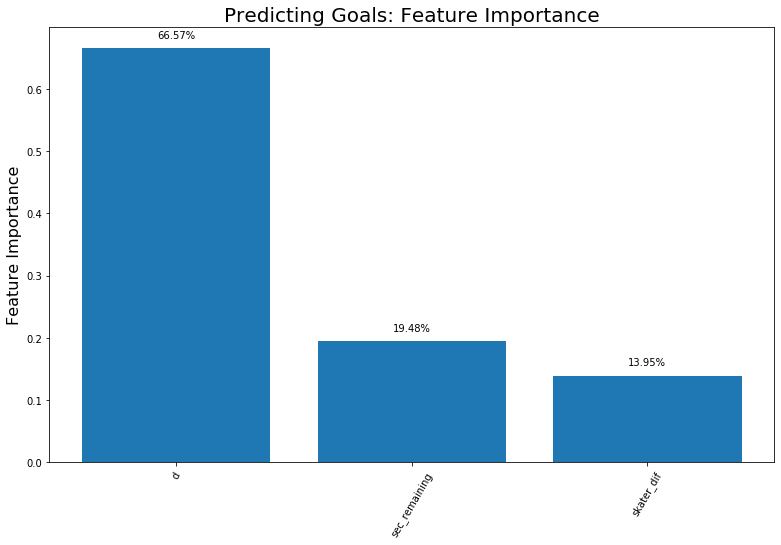

None


In [31]:
featu = pd.DataFrame(data = {'feat':features,'import':cv_clf.best_estimator_.feature_importances_})
featu=featu.sort_values(by='import',ascending=False)
a = featu['feat']
b = featu['import']
plt.figure(figsize=(13,8))
plt.bar(a,b)
# zip joins x and y coordinates in pairs
for a,b in zip(a,b):
    label = "{:.2%}".format(b)
    plt.annotate(label,
                 (a,b), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center') 
plt.title("Predicting Goals: Feature Importance",fontsize=20)
plt.xticks(rotation=60)
plt.ylabel("Feature Importance",fontsize=16)
print(plt.show())